In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
src = Path('./../demographics')

In [36]:
locs = {
    'heidelberg': 'L1', # 'HD',
    'munich': 'L2', # 'M',
    'muenster': 'L3', # 'MS'
    'goettingen': 'L4', # 'GOE',
    'frankfurt': 'L6'
}
dfs = []
# for df_path in src.iterdir():
for loc in locs:
    df_path = src / f'{loc}.csv'
    print(df_path.stem)
    df = pd.read_csv(df_path, index_col=0)
    print(df.shape)
    df['Location'] = locs[df_path.stem]
    df['PatientAge'] = df['PatientAge'].apply(lambda x: int(x[:-1]) if type(x) == str else x)
    df['Manufacturer'] = df.Manufacturer.apply(lambda x: x.lower().capitalize())
    dfs.append(df)

heidelberg
(1316, 18)
munich
(1813, 18)
muenster
(3001, 18)
goettingen
(1829, 18)
frankfurt
(74, 18)


In [37]:
df = pd.concat(dfs).reset_index()

In [38]:
desc_df = df.describe().T
desc_df.loc[[x for x in desc_df.index  if x not in ['index', 'StudyDate']]]

,count,mean,std,min,25%,50%,75%,max
PatientAge,6176.0,80.920984,6.759913,24.0,78.00,82.00,85.00,106.00
PatientSize,1241.0,1.691136,0.459102,0.0,1.62,1.69,1.75,17.17
Exposure,8001.0,315.741282,159.917490,24.0,204.00,292.00,389.00,799.00
ExposureTime,8001.0,437.996625,338.224454,210.0,285.00,285.00,330.00,7761.00
XRayTubeCurrent,8001.0,896.335958,323.333314,20.0,669.00,871.00,1114.00,2541.00
ContrastBolusVolume,7319.0,39.475243,41.164030,0.0,0.00,60.00,80.00,170.00
ContrastBolusTotalDose,7319.0,38.468977,39.614042,0.0,0.00,60.00,80.00,128.70
ContrastBolusIngredientConcentration,7319.0,195.431070,185.779793,0.0,0.00,350.00,370.00,400.00


In [39]:
def adjust_modelname(x):
    m = x['Manufacturer']
    mmn = x['ManufacturerModelName']
    if mmn == 'SOMATOM Definition':
        mmn = 'SOMATOM Definition Flash'
    elif mmn == 'IQon - Spectral CT':
        mmn = 'IQon Elite Spectral CT'
    elif mmn == 'Spectral CT':
        mmn = 'Spectral CT 7500'
    elif mmn == 'iCT 256':
        mmn = 'CT 6000 iCT'
    elif str(mmn) == 'nan':
        return mmn
    return f'{m[0]}/{mmn}'

df['Manufacturer/ManufacturerModelName'] = df.apply(adjust_modelname, axis=1)
manufacturer_df = df.groupby(['Location', 'Manufacturer/ManufacturerModelName']).size().reset_index(name='count')

In [64]:
def sqrt_transform(values):
    return np.sqrt(values)

def sqrt_inverse_transform(values):
    return np.square(values)

# Custom formatter for the y-axis labels
def sqrt_format(y, pos):
    return f'{y**2:.2f}'

/tmp/ipykernel_1796866/891639619.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([10,100,1000])
/tmp/ipykernel_1796866/891639619.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=x, hue='Location', ax=ax, fill=True, legend=i==3) #, order=list(locs.values()))


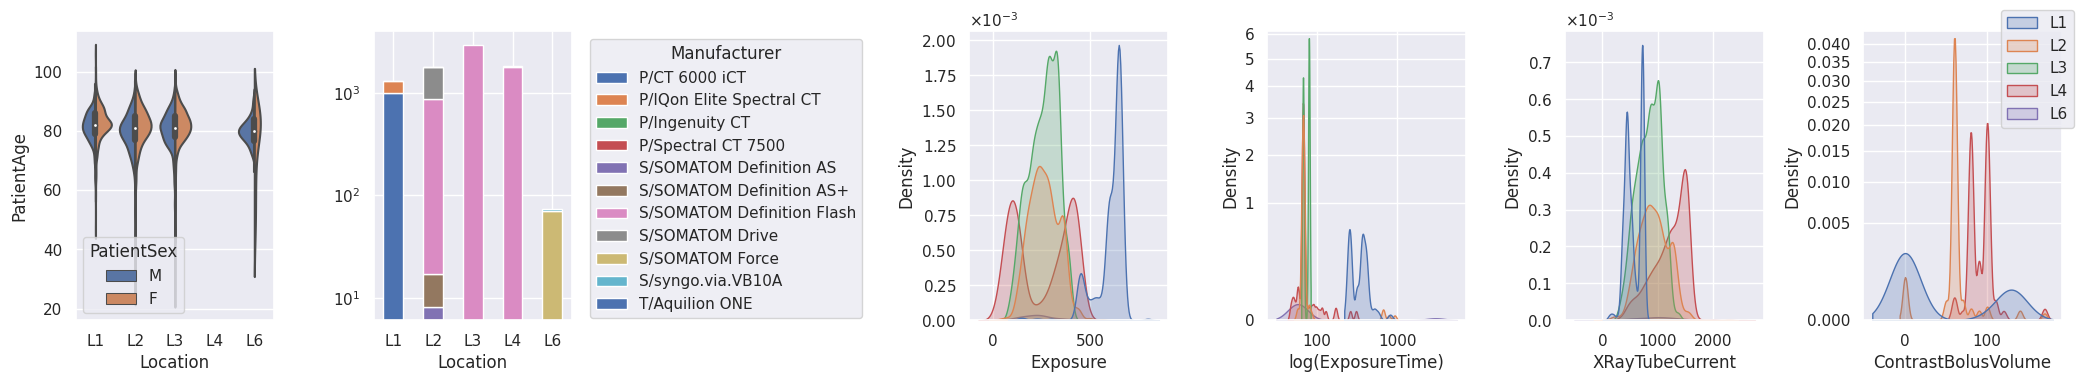

In [67]:
import matplotlib.ticker as mticker

numeric_cols = [
    # 'PatientAge', 
    # 'PatientSize', 
    'Exposure', 
    'log(ExposureTime)', 
    'XRayTubeCurrent', 
    'ContrastBolusVolume', 
    # 'ContrastBolusTotalDose',
    # 'ContrastBolusIngredientConcentration'
]
sns.set()
fig, axs = plt.subplots(1, 7, figsize=(21,4))
sns.violinplot(data=df, x='Location', y='PatientAge', hue='PatientSex', split=True, ax=axs[0], order=list(locs.values()))
pivot_df = manufacturer_df.pivot_table(index='Location', columns='Manufacturer/ManufacturerModelName', values='count', fill_value=0)
pivot_df.plot(kind='bar', stacked=True, ax=axs[1])#, legend=True) #, order=list(locs.values()))
axs[1].set_yscale('log')
# handles, labels = axs[1].legend_.legendHandles, [text.get_text() for text in axs[1].legend_.texts]
# axs[1].legend(handles=handles, labels=labels, fontsize=8)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=0)
handles, labels = axs[1].get_legend_handles_labels()
axs[2].legend(handles=handles, labels=labels, title='Manufacturer')
axs[1].get_legend().remove()
axs[2].axis('off')  # Turn off the axis for subplot 3
df['log(ExposureTime)'] = np.log(df['ExposureTime'])
for i, (ax, x) in enumerate(zip(axs[3:], numeric_cols)):
    sns.kdeplot(data=df, x=x, hue='Location', ax=ax, fill=True, legend=i==3) #, order=list(locs.values()))
    # handles, labels = [], []
    # for loc, short in locs.items():
    #     kdeplot = sns.kdeplot(df[df.Location==loc][x], label=short, ax=ax)
    #     handle = kdeplot.get_lines()[-1]
    #     handles.append(handle)
    #     labels.append(short)
    # ax.legend(handles=handles, labels=labels)
    if 'log' in x:
        ax.set_xticklabels([10,100,1000])        
    if i in [0,2,3]:
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, -3))  # Sets the lower and upper limit to 10e-3
        ax.yaxis.set_major_formatter(formatter)
    if ax.legend_:
        handles, labels = ax.legend_.legendHandles, [text.get_text() for text in ax.legend_.texts]
        ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.1,1.1))



axs[4].set_yscale('function', functions=(sqrt_transform, sqrt_inverse_transform))
axs[6].set_yscale('function', functions=(sqrt_transform, sqrt_inverse_transform))
fig.tight_layout()
fig.savefig('../images/demographics.pdf', bbox_inches='tight')